In [1]:
# 2023 -- Currency rate Prediction

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
# Reading and decopmosition:
df = pd.read_csv('Daily_Currency.csv')
# df = df.drop(columns='Unnamed: 2')

In [4]:
df['date'].replace(regex=True,inplace=True, to_replace='M',value='')
df['date'] =  pd.to_datetime(df['date'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df = df.set_index(['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1478 entries, 2019-01-01 to 2023-01-23
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   currency  1478 non-null   int64
dtypes: int64(1)
memory usage: 23.1 KB


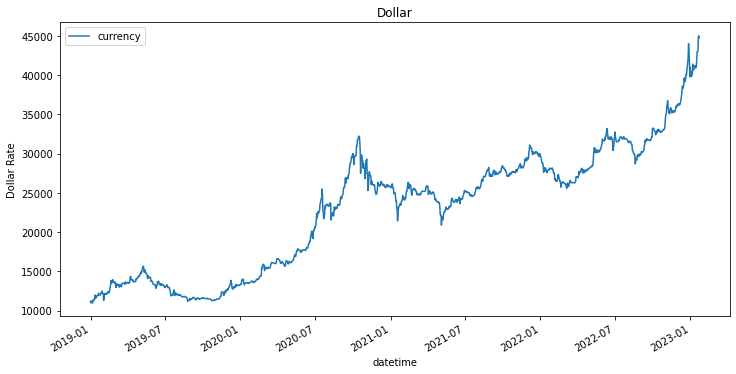

In [5]:
from pylab import rcParams  
rcParams['figure.figsize'] = 12, 6
df.plot()
plt.xlabel('datetime')
plt.ylabel('Dollar Rate')
plt.title("Dollar")
plt.savefig('Dollar_Rate_2023.jpg')

In [6]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(df.values)

Test Statistic                    0.808563
p-value                           0.991773
#Lags Used                       22.000000
Number of Observations Used    1455.000000
Critical Value (1%)              -3.434852
Critical Value (5%)              -2.863528
Critical Value (10%)             -2.567829
dtype: float64

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


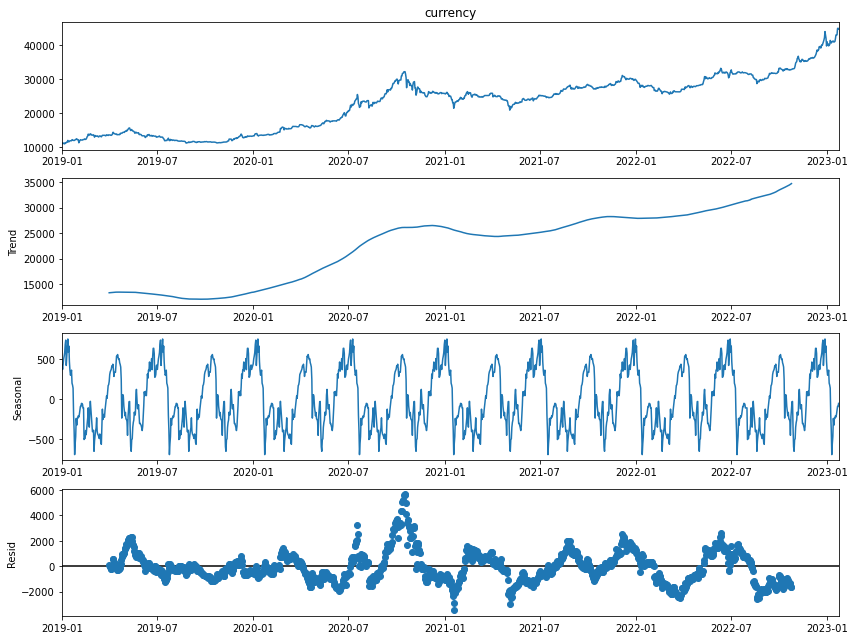

In [7]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['currency'], model='additive',period = 180)

rcParams['figure.figsize'] = 12, 9
# plt.rc('lines', linewidth=1, color='r')

fig = result.plot()
print(plt.style.available)
plt.savefig('Dollar_Decomposition.jpg')

           currency
count   1478.000000
mean   22949.323410
std     7901.665676
min    11000.000000
25%    14050.000000
50%    24900.000000
75%    28170.000000
max    45000.000000


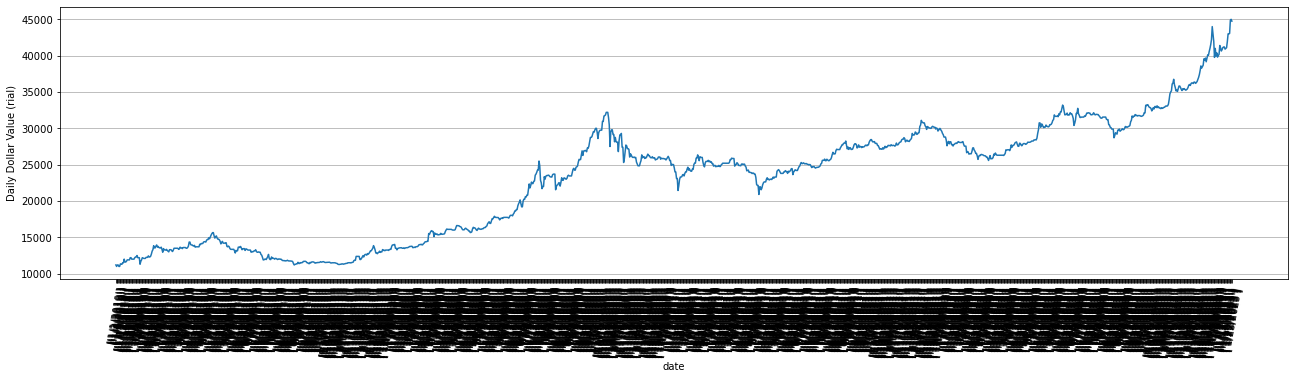

In [8]:
dataset = pd.read_csv('Daily_Currency.csv', usecols=[1], engine='python')
dataset2 = pd.read_csv('Daily_Currency.csv', usecols=[0], engine='python')
date = dataset2.values.astype('str')
print(dataset.describe())
# print(dataset.tail(12))

plt.figure(figsize=(22, 5))
plt.grid(axis = 'y')
plt.plot(dataset)
plt.xlabel('date')
plt.ylabel('Daily Dollar Value (rial)')
plt.xticks([i for i in range(len(dataset))],list(date),rotation = 80)
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [10]:
# fix random seed for reproducibility
tf.random.set_seed(7)
dataframe = pd.read_csv('Daily_Currency.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset) #.reshape(1,-1)

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.72)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1064 414


In [12]:
# convert an array of values into a dataset matrix
import numpy as np
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [13]:
# reshape into X=t and Y=t+1
look_back = 180
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1)) # make 2D into 3D -- we give 2 last D as input
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) # make 2D into 3D
# print(testX)

In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(60,return_sequences=True,input_shape=(look_back,1)))
model.add(LSTM(60,return_sequences=True))
model.add(LSTM(60))
# model.add(LSTM(5,input_shape=(1, look_back))) ## 4 hidden layer -- 
# model.add(LSTM(5))#, return_sequence = True
model.add(Dense(1)) # Final output
model.compile(loss='mean_squared_error', optimizer='adam')


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 60)           14880     
                                                                 
 lstm_1 (LSTM)               (None, 180, 60)           29040     
                                                                 
 lstm_2 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 73,021
Trainable params: 73,021
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(trainX, trainY, epochs=2, batch_size=1, verbose=2)
model.save('my_model.h5')    # Save the structure and the weights all together

Epoch 1/2
883/883 - 46s - loss: 0.0021 - 46s/epoch - 52ms/step
Epoch 2/2
883/883 - 41s - loss: 8.5093e-04 - 41s/epoch - 47ms/step


In [16]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

8/8 [==============================] - 0s 37ms/step


In [17]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [18]:
trainY = scaler.inverse_transform(trainY.reshape(-1,1))
testY = scaler.inverse_transform(testY.reshape(-1,1))
# testY = scaler.inverse_transform([testY[0,:]])

In [19]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 908.20 RMSE
Test Score: 2824.13 RMSE


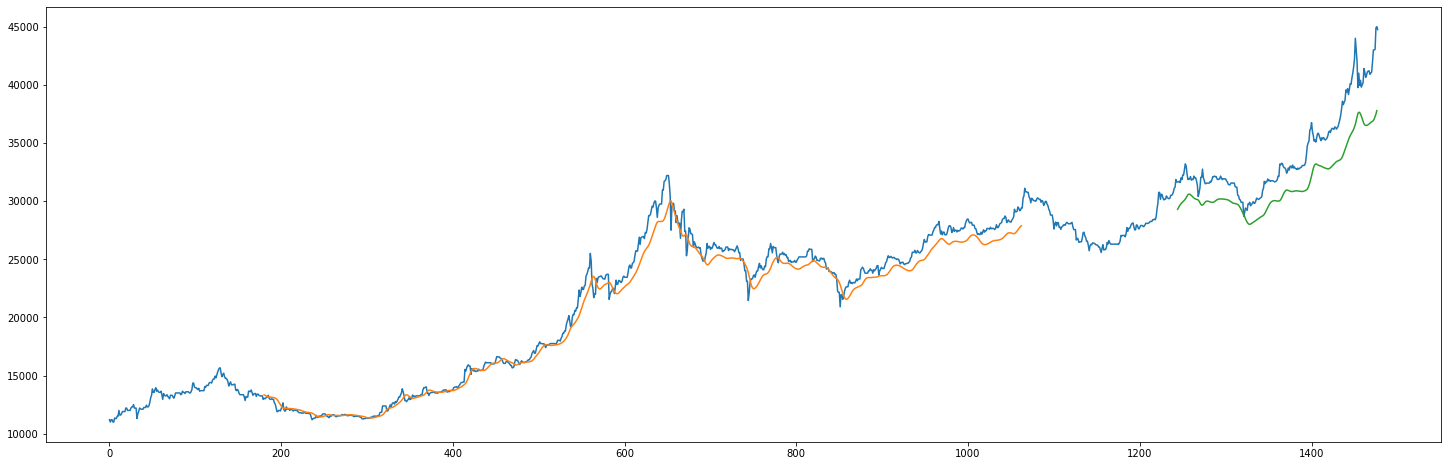

<Figure size 864x648 with 0 Axes>

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(25, 8))
plt.plot(scaler.inverse_transform(dataset)) # original
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
plt.savefig('LSTM_Dollar_Train_Test')

In [32]:
x_input=test[len(test)-look_back:].reshape(1,-1)
x_input.shape
temp_input = list(x_input)
temp_input = temp_input[0].tolist() # take all the values
# demonstrate prediction for next 10 days
from numpy import array
duration = 7
print(len(temp_input), temp_input, type(temp_input))
xxx = len(temp_input)
lst_output=[]
n_steps=look_back
i=0
while(i<=duration):
    if i>=1:
        print('ivalue is : ',i)
        x_input=np.array(temp_input)
#         print(x_input.shape)
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
        xxx = len(list(temp_input))
    else:
        print('FIRST')
        x_input = x_input.reshape((1, n_steps,1))
#         print(x_input)
        yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        xxx = len(list(temp_input))
        i=i+1
    

print(lst_output)
     

180 [0.6155882477760315, 0.6147059202194214, 0.6147059202194214, 0.6100000143051147, 0.6073529720306396, 0.6014705896377563, 0.6000000238418579, 0.6000000238418579, 0.604411780834198, 0.604411780834198, 0.604411780834198, 0.604411780834198, 0.604411780834198, 0.5955882668495178, 0.5941176414489746, 0.5941176414489746, 0.5735294222831726, 0.5720588564872742, 0.5632352828979492, 0.5617647171020508, 0.5558823347091675, 0.5558823347091675, 0.5558823347091675, 0.520588219165802, 0.529411792755127, 0.5411764979362488, 0.5382353067398071, 0.5352941155433655, 0.5514705777168274, 0.5514705777168274, 0.5558823347091675, 0.5470588207244873, 0.550000011920929, 0.5529412031173706, 0.5573529601097107, 0.5535294413566589, 0.5535294413566589, 0.5588235259056091, 0.5661764740943909, 0.5652941465377808, 0.5629411935806274, 0.5641176700592041, 0.5661764740943909, 0.5676470398902893, 0.5699999928474426, 0.5852941274642944, 0.5911765098571777, 0.6088235378265381, 0.6029412150382996, 0.607941210269928, 0.60